<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Test-1---Running-Various-Untuned-Classifiers-and-picking-some-for-extensive-testing" data-toc-modified-id="Test-1---Running-Various-Untuned-Classifiers-and-picking-some-for-extensive-testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Test 1 - Running Various Untuned Classifiers and picking some for extensive testing</a></span></li><li><span><a href="#Test-2---Hyperparameter-tuning-for-Random-Forest" data-toc-modified-id="Test-2---Hyperparameter-tuning-for-Random-Forest-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test 2 - Hyperparameter tuning for Random Forest</a></span><ul class="toc-item"><li><span><a href="#Experimenting-with-Decision-Tree-for-Biological-Interpretability" data-toc-modified-id="Experimenting-with-Decision-Tree-for-Biological-Interpretability-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Experimenting with Decision Tree for Biological Interpretability</a></span></li><li><span><a href="#Tuning-Random-Forest" data-toc-modified-id="Tuning-Random-Forest-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Tuning Random Forest</a></span></li></ul></li><li><span><a href="#Tuning-SVMs-and-LR-with-X_signature" data-toc-modified-id="Tuning-SVMs-and-LR-with-X_signature-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tuning SVMs and LR with X_signature</a></span></li><li><span><a href="#Final-Test-with-multivariate-feature-selection" data-toc-modified-id="Final-Test-with-multivariate-feature-selection-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Final Test with multivariate feature selection</a></span></li></ul></div>

In [1]:
# Packages

import sys
print("Python version: {}". format(sys.version))

import os
print("OS version: {}". format(os.uname()))

import pandas as pd
print("pandas version: {}". format(pd.__version__))

import matplotlib
print("matplotlib version: {}". format(matplotlib.__version__))
import matplotlib.pyplot as plt

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp 
print("SciPy version: {}". format(sp.__version__)) 

import sklearn 
print("scikit-learn version: {}". format(sklearn.__version__))

#misc
import random
import time

print('-'*25)

Python version: 3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
OS version: posix.uname_result(sysname='Darwin', nodename='Bings-MacBook-Pro.local', release='17.4.0', version='Darwin Kernel Version 17.4.0: Sun Dec 17 09:19:54 PST 2017; root:xnu-4570.41.2~1/RELEASE_X86_64', machine='x86_64')
pandas version: 0.23.1
matplotlib version: 2.2.2
NumPy version: 1.14.5
SciPy version: 1.1.0
scikit-learn version: 0.19.1
-------------------------


In [2]:
PATH = "AML-DATA/"

# 250 top scoring genes
X_250 = pd.read_csv(PATH + "X_subset_250.csv", index_col = 0)

# 24 gene-signature derived from bigX
X_signature = pd.read_csv(PATH + "X_signature_24.csv", index_col = 0)

# Right now pkl version of file doesn't have DataFrame/Series type problem (as opposed to csv version)
y = pd.read_pickle(PATH + "PROCESSED-TARGET-AML-Y.pkl")

## Test 1 - Running Various Untuned Classifiers and picking some for extensive testing

Not testing Random Forest, Voting, and Gradient Boosting here, but they will be used in final testing (computational reasons)


RESULTS:

* All SVM variations and Logistic Regression are promising with more tuning

* L2-SVM in particular achieves above .98 score in all 3 metrics, better than previous studies

* Additionally - replacing X_signature with X_250 in the "Actual Testing" cell provides evidence that the L1-SVM feature selection was effective.

In [3]:
# Various Classifiers
from sklearn.svm import SVC # RBF kernel SVM
from sklearn.svm import LinearSVC # L1 and L2 reg. SVMs
from sklearn.neighbors import KNeighborsClassifier # K-nearest neighbors (needs some extra tuning here for k)
from sklearn.linear_model import LogisticRegression # L2 reg. Logistic Regression
from sklearn.naive_bayes import GaussianNB # Naive Bayes
from sklearn.ensemble import RandomForestClassifier

# Model validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from tqdm import tqdm_notebook

In [4]:
# SET UP

k_fold = RepeatedStratifiedKFold(10, n_repeats = 10, random_state = 100)

# Keys = classifiers, stored-values = [accuracy, roc_aucs, f1]
clfDict = {SVC(kernel = "rbf") : [[],[],[]],
           
           LinearSVC(penalty = "l1", dual = False) : [[],[],[]], LinearSVC(penalty = "l2") : [[],[],[]], 
           
           KNeighborsClassifier(n_neighbors = 8, p = 3): [[],[],[]],
           
           LogisticRegression(C = 0.01) : [[],[],[]],
           
           GaussianNB() : [[],[],[]],
           
           RandomForestClassifier(max_depth = 3, max_features = 'sqrt', min_samples_leaf = 2,
                                  min_samples_split = 2, n_estimators = 300) : [[],[],[]]
          }

In [6]:
# ACTUAL TESTING


for clf in tqdm_notebook(clfDict.keys()):
    
    k = 1
    for k, (train, test) in enumerate(k_fold.split(X_signature, y)):

        clf.fit(X_signature.iloc[train], y.iloc[train])
       
    
        y_pred = clf.predict(X_signature.iloc[test])
        
        accuracy = accuracy_score(y.iloc[test], y_pred)
        roc_auc = roc_auc_score(y.iloc[test], y_pred)
        f1 = f1_score(y.iloc[test], y_pred)
        
        clfDict[clf][0].append(accuracy)
        clfDict[clf][1].append(roc_auc)
        clfDict[clf][2].append(f1)

        

In [7]:
# VIEW RESULTS
from statistics import mean

results = pd.DataFrame.from_dict(clfDict)
results.columns = ["RBF-SVM", "L1-SVM", "L2-SVM", "KNN", "L1_LR", "GNB", "RF"]
results.index = ["mean accuracy", "area under ROC curve", "f1 score"]
results = results.applymap(lambda x: mean(x))

display(results)

,RBF-SVM,L1-SVM,L2-SVM,KNN,L1_LR,GNB,RF
mean accuracy,0.831688,0.878268,0.875866,0.705952,0.799957,0.773896,0.721537
area under ROC curve,0.831636,0.878500,0.876091,0.709364,0.800682,0.774727,0.721238
f1 score,0.832304,0.878129,0.875177,0.659169,0.794695,0.766704,0.726990


## Test 2 - Hyperparameter tuning for Random Forest

Before integrating all the different classifiers in a single test, it's computationally beneficial to tune the random forest separately and use set hyperparameters, instead of needing to tune on-the-go. 



### Experimenting with Decision Tree for Biological Interpretability

In [8]:
# SETUP
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

# Hyperparameters
max_features = ['sqrt'] # Max num of features considered every split
max_depth = [2, 3, 4, 5] # Max num of levels in whole tree
min_samples_split = [2, 5, 10] # Min num of samples required to split a node
min_samples_leaf = [2, 5] # Min num of samples required at each node
#bootstrap = [True, False] # Method of selecting samples for training each tree

# GridSearch Grid
grid = {'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
        #'bootstrap': bootstrap
       }


dtree = DecisionTreeClassifier()

In [11]:
# RUN

tree_grid = GridSearchCV(dtree, grid, cv = 10, verbose = 1, n_jobs = -1, scoring = "f1")
tree_grid.fit(X_signature, y)

print(tree_grid.best_params_)
print(tree_grid.best_score_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}
0.6645256744033005


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.6s finished


In [10]:
# RESULTS

cv_results = pd.DataFrame(tree_grid.cv_results_).sort_values(by="rank_test_score")
#display(cv_results)

/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/alecx/anaconda/lib/python3.

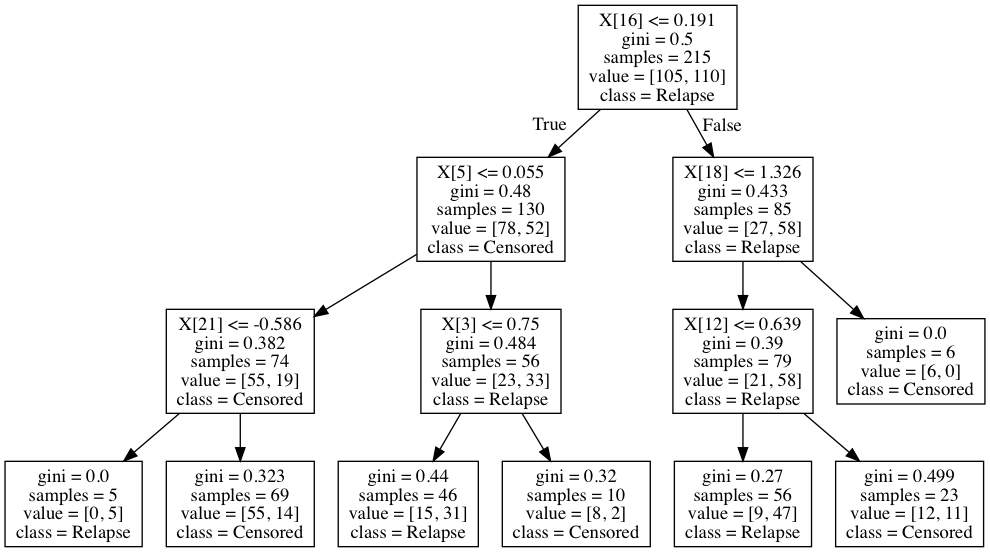

In [32]:
# PRINT BEST TREE
from IPython.display import Image  
import pydotplus
from sklearn import tree

bestTree = DecisionTreeClassifier(max_features = "sqrt", max_depth = 3, min_samples_leaf = 5, min_samples_split = 2)
bestTree.fit(X_signature, y)

# Create DOT data
dot_data = tree.export_graphviz(bestTree, out_file=None, 
                                class_names=["Censored", "Relapse"])

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

### Tuning Random Forest

Reference: Table from http://blog.kaggle.com/2016/07/21/approaching-almost-any-machine-learning-problem-abhishek-thakur/ used for grid basis

In [13]:
# SETUP
from sklearn.ensemble import RandomForestClassifier


# Hyperparameters
criterion = ["gini"] # function for split quality measure
n_estimators = [500] # Num of trees in Random Forest
max_features = ['sqrt'] # Max num of features considered every split
max_depth = [3, 4, 5, 6, 7] # Max num of levels in each forest tree
min_samples_split = [2, 5, 10] # Min num of samples needed to split a node
min_samples_leaf = [2, 5] # Min num of samples needed at every node
# Method of selecting samples for training each tree

# RandomSearch Grid
forest_grid = {"criterion" : criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf = RandomForestClassifier()

In [14]:
# RUN
rf_random = GridSearchCV(rf, forest_grid, cv = 10, verbose = 1, scoring = "f1", n_jobs = -1)

# Fit rf_random model
rf_random.fit(X_signature, y)


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s


KeyboardInterrupt: 

In [ ]:
print(rf_random.best_params_)
print(rf_random.best_score_)

In [ ]:
rf_cv_results = pd.DataFrame(rf_random.cv_results_)
display(rf_cv_results.sort_values(by="rank_test_score").drop(rf_cv_results.columns[0:5], axis = 1))
rf_cv_results.to_pickle("RFSweep3")


## Tuning SVMs and LR with X_signature

Results:
rbfSVM - {'C': 10, 'gamma': 0.01}, F1 = 0.94

L1SVM - {'C': 10}, F1 = 0.93

L2SVM - {'C': 0.1}, F1 = 0.99

LR - {'C': 1, 'penalty': 'l2'}, F1 = 0.99



In [15]:
# RBFSVM
rbfSVM = SVC(kernel = "rbf")

# Hyperparameters
rbf_C = [0.0001, 0.001, 0.01, 0.1, 1, 10]
rbf_gamma = [0.0001, 0.001, 0.01, 0.1, 1, 10, "auto"]
rbf_grid = {"C" : rbf_C, 
            "gamma" : rbf_gamma}

# GRIDSEARCH
rbf_search = GridSearchCV(rbfSVM, rbf_grid, cv = 10, verbose = 1, scoring = "accuracy", n_jobs = -1)
rbf_search.fit(X_signature, y)

print(rbf_search.best_params_)
print(rbf_search.best_score_)

Fitting 10 folds for each of 42 candidates, totalling 420 fits
{'C': 10, 'gamma': 0.01}
0.8651162790697674


[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:    1.2s finished


In [16]:
# L1SVM
L1SVM = LinearSVC(penalty = "l1", dual = False)

# Hyperparameters
L1_C = [0.0001, 0.001, 0.01, 0.1, 1, 10]
L1_grid = {"C" : L1_C}

# GRIDSEARCH
L1_search = GridSearchCV(L1SVM, L1_grid, cv = 10, verbose = 1, scoring = "accuracy", n_jobs = -1)
L1_search.fit(X_signature, y)

print(L1_search.best_params_)
print(L1_search.best_score_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'C': 0.1}
0.8744186046511628


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.2s finished


In [17]:
# L2SVM
L2SVM = LinearSVC(penalty = "l2")

# Hyperparameters
L2_C = [0.0001, 0.001, 0.01, 0.1, 1, 10]
L2_grid = {"C" : L2_C}

# GRIDSEARCH
L2_search = GridSearchCV(L2SVM, L2_grid, cv = 10, verbose = 1, scoring = "accuracy", n_jobs = -1)
L2_search.fit(X_signature, y)

print(L2_search.best_params_)
print(L2_search.best_score_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'C': 0.1}
0.8930232558139535


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.2s finished


In [18]:
# Logistic Regression
LR = LogisticRegression()

# Hyperparameters
LR_penalty = ["l1", "l2"]
LR_C = [0.0001, 0.001, 0.01, 0.1, 1, 10]
LR_grid = {"penalty" : LR_penalty, "C" : LR_C}

# GRIDSEARCH
LR_search = GridSearchCV(LR, LR_grid, cv = 10, verbose = 1, scoring = "f1", n_jobs = -1)
LR_search.fit(X_signature, y)

print(LR_search.best_params_)
print(LR_search.best_score_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alecx/anaconda/lib/python3.6/site-packages/sklearn/metric

{'C': 1, 'penalty': 'l2'}
0.9002679111816465


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.4s finished


## Final Test with multivariate feature selection
locally linear embedding

* Inner loop feature selection from X_250
* Tuned models
* 10 times 10-fold stratified cross validation

In [28]:
from sklearn.feature_selection import SelectFromModel
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA


In [29]:
# SET UP

k_fold = RepeatedStratifiedKFold(10, n_repeats = 5, random_state = 100)

finalClassifiers = {SVC(kernel = "rbf", gamma = 0.01, C=10) : [[],[],[]],
           
                   LinearSVC(penalty = "l1", dual = False, C=0.1) : [[],[],[]], 
                
                   LinearSVC(penalty = "l2", C=0.1): [[],[],[]], 
                    
                   LogisticRegression(penalty = "l2") : [[],[],[]],

                   RandomForestClassifier(criterion = "gini", max_depth = 5, max_features = 'sqrt', min_samples_leaf = 2,
                                          min_samples_split = 2, n_estimators = 300) : [[],[],[]]
                   }


In [30]:
# Outer loop is each fold, inner loop is each classifier tested on that fold

k = 1
for k, (train, test) in tqdm_notebook(enumerate(k_fold.split(X_250, y))):
    
    # Multivariate feature selection with L1 Reg Linear SVM
    X_train_L1 = X_250.iloc[train].copy()
    X_test_L1 = X_250.iloc[test].copy()
    L1_SVM = LinearSVC(penalty = "l1", C = 1.0, dual=False, random_state = 100)
    bestGetter = SelectFromModel(L1_SVM, "median")
    X_train_L1 = bestGetter.fit_transform(X_train_L1, y.iloc[train])
    X_test_L1 = bestGetter.transform(X_test_L1)
    pca = PCA(n_components = 20)
    #X_train_L1 = pca.fit_transform(X_train_L1)
    #X_test_L1 = pca.transform(X_test_L1)
    
    # Isomap
    X_train_isomap = X_250.iloc[train].copy()
    X_test_isomap = X_250.iloc[test].copy()
    isomapper = Isomap(n_components = 50)
    X_train_isomap = isomapper.fit_transform(X_train_isomap)
    X_test_isomap = isomapper.transform(X_test_isomap)
    
    for clf in finalClassifiers.keys():
        
        # L1
        clf.fit(X_train_L1, y.iloc[train])
        y_pred = clf.predict(X_test_L1)
        accuracy = accuracy_score(y.iloc[test], y_pred)
        roc_auc = roc_auc_score(y.iloc[test], y_pred)
        f1 = f1_score(y.iloc[test], y_pred)
        finalClassifiers[clf][0].append(accuracy)
        finalClassifiers[clf][1].append(roc_auc)
        finalClassifiers[clf][2].append(f1)
        '''
        
        # Isomap
        clf.fit(X_train_isomap, y.iloc[train])
        y_pred = clf.predict(X_test_isomap)
        accuracy = accuracy_score(y.iloc[test], y_pred)
        roc_auc = roc_auc_score(y.iloc[test], y_pred)
        f1 = f1_score(y.iloc[test], y_pred)
        finalClassifiers[clf][0].append(accuracy)
        finalClassifiers[clf][1].append(roc_auc)
        finalClassifiers[clf][2].append(f1)
        '''

In [31]:
# VIEW RESULTS
from statistics import mean

results = pd.DataFrame.from_dict(finalClassifiers)
results.columns = ["RBF-SVM", "L1-SVM", "L2-SVM", "L2-LR", "RF"]
results.index = ["Acc", "AUC", "F1"]
results = results.applymap(lambda x: mean(x))


display(results)

,RBF-SVM,L1-SVM,L2-SVM,L2-LR,RF
Acc,0.745238,0.793680,0.806797,0.817013,0.701602
AUC,0.744909,0.794182,0.807545,0.817636,0.701455
F1,0.753431,0.789003,0.801929,0.815203,0.701027
